In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
import os
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from queue import *



**Data collection**

---



1.   Data for bitcoin is queried form google Bigdata.
2.   I have used my authentication.
3.   I have already saved the csv files so there is no      need to run the query again
4.   The user can skip to preprocessing directely.















In [0]:
from bq_helper import BigQueryHelper
# this bq_helper can be installed with pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper

auth_path = "drive/My Drive/bitcoin/bitcoin 2-a8cb46913b9c.json"
# auth_path is location of your google cloud json file. needed for querying.
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= auth_path

In [0]:
bq_assist = BigQueryHelper(active_project= "bigquery-public-data", dataset_name = "bitcoin_blockchain")
# I extract tables from bitcoin_blockchain dataset  
bq_assist.list_tables()

**There are two tables in the dataset**
1.   Blocks
2.   Transaction
---
I am primarily interested in Transaction as we cluster bitcoin addresses on the basis of the amount of money exchanged.  

---
We want to extract 3 information.


1.   input_address
2.   output_address
3.   amount of bitcoin transferred









In [0]:
query = """
SELECT
    inputs.input_pubkey_base58 AS input_key,
    outputs.output_pubkey_base58 AS output_key,
    SUM(outputs.output_satoshis) as satoshis
FROM `bigquery-public-data.bitcoin_blockchain.transactions`
    JOIN UNNEST (inputs) AS inputs
    JOIN UNNEST (outputs) AS outputs
WHERE timestamp >= 1293840000000
    AND timestamp <= 1325376000000
    
    AND inputs.input_pubkey_base58 IS NOT NULL
    AND outputs.output_pubkey_base58 IS NOT NULL
GROUP BY input_key, output_key
LIMIT 2500000
"""

This query extracts all the transactions made in 2011.


1.   Grouped by input_address and output_address            (transaction amount as added up)
2.   We remove transactions with input or output as        None(These are generally online betting games)



---
I have extracted 3 data sets.
 

1.   data for 2010
2.   data for 2011
3.   data for first 2 months for 2011




In [0]:
bq_assist.estimate_query_size(query)
# estimation query size before running 

64.56548567861319

In [0]:
data_save_path = "drive/My Drive/bitcoin/2011_transactions.csv"
#df = bq_assist.query_to_pandas_safe(query, max_gb_scanned= 70)  #uncomment if you want to run the query again
#df.to_csv(data_save_path , index = None)


# running this wil get the data into df as a pandas dataframe and finally store it at data_save_path as csv
#beware its will be a very large dataset
#There we almost 60k transactions per day in 2011!!

# Processing the data
The goal is to make both directed and undirected graphs for analyzing the data and clusterring addresses

The graphs have all the unique addresses as nodes and transactions as weighted edges.




In [5]:
df = pd.read_csv(data_save_path)
df.head()

,input_key,output_key,satoshis
0,16xXj3T5ujZ3LtxPNza7eEz6fbk62YiWb6,1GBpxPrToaqBsgiL32vdRf39EmevuzeYCy,991898940
1,1BQg9aXxS88Enpa74ySUmMZWaKEb633GeM,1L5Kp632Cf6oe4G2CvK3x8MzVpbsWcaXHo,1576621
2,1PJnjo4n2Rt5jWTUrCRr4inK2XmFPXqFC7,12RByqNNXmNpdUtdgV4T3k4YAW5F7oPxQA,526000000
3,179BCw6ZsHJMzQcgLcFnFN8unoFqtq4QZm,1fG1298c7NeuV8N78dBNVVmeWDF5fzQqe,7000000
4,1DkrM9zhYuTWpYKqqniD1y7cF8oRVt896b,1JPzWjaEBfqcCKX8Y8J6P5QPu6bQ9RGfSZ,125684937


In [0]:
#converting satoshis to bitcoin
data = df.values.tolist()
for i in range(len(data)):
    data[i][2] = data[i][2]/100000000

In [0]:
class Node:
    def __init__(self , name):
        self.name = name
        self.adj = []
        self.visited = False
        
        
class my_graph:
    def __init__(self , edge_list):
        self.edge_list = edge_list
        self.uniq = {}
        self.mx = 0
        self.cluster = []
    def create_nodes(self):
        edge_list = self.edge_list
        uniq = self.uniq
        for e in edge_list:
            if(e[0] not in uniq):
                uniq[e[0]] = Node(e[0])
            if(e[1] not in uniq):
                uniq[e[1]] = Node(e[1])
            
    def create_graph(self):
        self.create_nodes()
        edge_list = self.edge_list
        for e in edge_list:
            self.uniq[e[0]].adj.append(self.uniq[e[1]])
            self.uniq[e[1]].adj.append(self.uniq[e[0]])
            
    def bfs(self , start):
        Q = Queue()
        Q.put(start)
        count = 0
        start.visited = True
        while(Q.empty() == False):
            count = count + 1
            current = Q.get()
            for n in current.adj:
                if(n.visited == False):
                    Q.put(n)
                    n.visited = True
                
        return count
    def compare(self, A , B):
        if(A[1] > B[1]):
            return 1
        elif(A[1] < B[1]):
            return -1
        else:
            return 0
        
    def max_network(self):
        vertices = self.uniq
        for v in vertices:
            if(vertices[v].visited == False):
                self.cluster.append([v,self.bfs(vertices[v])])
    def summary(self):
        print(str(len(self.cluster)) + " total clusters")
        return self.cluster
    def reset(self):
        for v in self.uniq:
            self.uniq[v].visited = False
       
        

In [0]:
g = my_graph(data)
g.create_graph()
g.max_network()

The above code just created a non directional graph and counted the nodes in each strongly connected components for the graph. 

1.   let us first cluster according to the components 
2.   Two different clusters have no transactions to        link them so its point less to use them together      in a clusterring algorithm



In [0]:
arr = g.cluster
g.reset()

"arr" contains ["address" , "components_size"]

Because to access a strongly connected component only one node is enough

now for this demonstration purpose i am intrested in all the component that are larger than 1000 nodes

In [10]:
print("node from scomponent            component size")
for c in arr:
    if(c[1] > 1000):
        print(c[0] , c[1])

node from scomponent            component size
16xXj3T5ujZ3LtxPNza7eEz6fbk62YiWb6 1488004
1MaZAHzEFfinRJ2dwK6YtNDfvWMBkiAxDr 102643
18ZDrJFNwynkdfGUhyHSmNCsbAdMhjDjHt 1916
1Eu9LhFCcTTNjg7rTG84rgyNgNCFWxHkMG 1505


We have extracted address for all clusters that are over 1000 addresses....
And look the largest cluster is 14 lac !!!


---

But at this point of time they are just random addresses...


1.   We will now assign each node a 100 dimentional        vector
2.   Then use random walks to generate sequences of addresses
3. We will train and cluster addressed         according to these sequences formed. 
3.   The idea for node-to-vector is explored in    https://web.cs.wpi.edu/~xkong/publications/papers/cikm17.pdf
4. I have explained the random walk in my report.
5. There are several benefits of random
walks over pure BFS/DFS approaches. Random walks are computationally efficient in terms of both space and time requirements.
The space complexity to store the immediate neighbors of every
node in the graph is O(|E|).



In [0]:
class Graph():
	def __init__(self, nx_G, is_directed, p, q):
		self.G = nx_G
		self.is_directed = is_directed
		self.p = p
		self.q = q

	def node2vec_walk(self, walk_length, start_node):
		'''
		Simulate a random walk starting from start node.
		'''
		G = self.G
		alias_nodes = self.alias_nodes
		alias_edges = self.alias_edges

		walk = [start_node]

		while len(walk) < walk_length:
			cur = walk[-1]
			cur_nbrs = sorted(G.neighbors(cur))
			if len(cur_nbrs) > 0:
				if len(walk) == 1:
					walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
				else:
					prev = walk[-2]
					next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
						alias_edges[(prev, cur)][1])]
					walk.append(next)
			else:
				break

		return walk

	def simulate_walks(self, num_walks, walk_length):
		'''
		Repeatedly simulate random walks from each node.
		'''
		G = self.G
		walks = []
		nodes = list(G.nodes())
		print ('Walk iteration:')
		for walk_iter in range(num_walks):
			print (str(walk_iter+1), '/', str(num_walks))
			random.shuffle(nodes)
			for node in nodes:
				walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

		return walks

	def get_alias_edge(self, src, dst):
		'''
		Get the alias edge setup lists for a given edge.
		'''
		G = self.G
		p = self.p
		q = self.q

		unnormalized_probs = []
		for dst_nbr in sorted(G.neighbors(dst)):
			if dst_nbr == src:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
			elif G.has_edge(dst_nbr, src):
				unnormalized_probs.append(G[dst][dst_nbr]['weight'])
			else:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
		norm_const = sum(unnormalized_probs)
		normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

		return alias_setup(normalized_probs)

	def preprocess_transition_probs(self):
		'''
		Preprocessing of transition probabilities for guiding the random walks.
		'''
		G = self.G
		is_directed = self.is_directed

		alias_nodes = {}
		for node in G.nodes():
			unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
			norm_const = sum(unnormalized_probs)
			normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
			alias_nodes[node] = alias_setup(normalized_probs)

		alias_edges = {}
		triads = {}

		if is_directed:
			for edge in G.edges():
				alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
		else:
			for edge in G.edges():
				alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
				alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

		self.alias_nodes = alias_nodes
		self.alias_edges = alias_edges

		return


def alias_setup(probs):
	K = len(probs)
	q = np.zeros(K)
	J = np.zeros(K, dtype=np.int)

	smaller = []
	larger = []
	for kk, prob in enumerate(probs):
	    q[kk] = K*prob
	    if q[kk] < 1.0:
	        smaller.append(kk)
	    else:
	        larger.append(kk)

	while len(smaller) > 0 and len(larger) > 0:
	    small = smaller.pop()
	    large = larger.pop()

	    J[small] = large
	    q[large] = q[large] + q[small] - 1.0
	    if q[large] < 1.0:
	        smaller.append(large)
	    else:
	        larger.append(large)

	return J, q

def alias_draw(J, q):
	'''
	Draw sample from a non-uniform discrete distribution using alias sampling.
	'''
	K = len(J)

	kk = int(np.floor(np.random.rand()*K))
	if np.random.rand() < q[kk]:
	    return kk
	else:
	    return J[kk]




**Now we will use a single node to get a particular component**

In [0]:
# This function gets all the nodes in a strongly connected component
def get_component_nodes(initial_address , graph):
    graph.reset()
    Q = Queue()
    Q.put(graph.uniq[initial_address])
    arr = [initial_address]
    graph.uniq[initial_address].visited = True
    while(Q.empty() == False):
        current = Q.get()
        arr.append(current.name)
        for n in current.adj:
            if(n.visited == False):
                Q.put(n)
                n.visited = True
    return arr
    

In [0]:
arr = get_component_nodes("18ZDrJFNwynkdfGUhyHSmNCsbAdMhjDjHt" , g)  # selecting one of the components that have above 1000 nodes
arr = set(arr)
# arr now contains all the nodes in a connected component

In [0]:
# we now extract all the edges that have any nodes from the selected connected component
processed_data = []
for d in data:
    if((d[0] in arr or d[1] in arr) and d[2] > 0):
        processed_data.append(d)
    
    

In [30]:
G_raw = nx.Graph()   # defining a graph using networkx
num_nodes = 10       # here num_nodes defines how many nodes do we cover for each random walk
num_walks = 5        # total number of times all the nodes will be put through walk algo

G_raw.add_weighted_edges_from(processed_data)
G = Graph(G_raw, False,p =  1, q = .5)     # here p ,q  are hyper-parameters guiding the random walk
G.preprocess_transition_probs()
walks = G.simulate_walks(num_walks, num_nodes)
walks = [list(map(str, walk)) for walk in walks]

hello
Walk iteration:
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5


# Training
Now that we have sequence of addresses we sinmply feed them to gensim's wordtovector model.

It applies CBOW model for learning node embeddings 

In [31]:
model = Word2Vec(walks, size=100, window=5, min_count=0, sg=0, workers=5 , iter = 20)
node_vectors = model.wv
X = model[model.wv.vocab]
#model.save("node2vec.model")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


We have obtained 100 dimentional vectors for each node. now lets try to visualize this in 2 dimention using PCA  


---

I have also used k means clustering and number of clusters has been set as 6. 
This is done to show the effectiveness of the method. 

In [0]:
n_clusters = 6   
km = KMeans(
    n_clusters=n_clusters, init='random',
    n_init=10, max_iter=3000, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

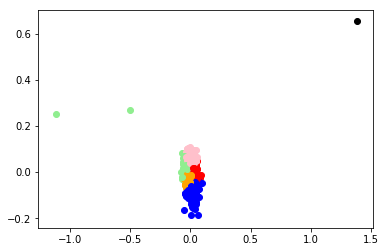

In [33]:
color = {0:"orange" , 1:"black" , 2:"blue" , 3:"red", 4:"lightgreen" , 5:"pink" , 6:"yellow"}
pca = PCA(n_components=2)
result = pca.fit_transform(X).tolist()
for i in range(len(result)):
    plt.scatter(result[i][0]  , result[i][1] , c = color[y_km[i]])
    
plt.show()    

**These are the results from clustering drawn on a 2-D plane**

In [0]:
# the mapping from all the addresses to their corrosponding vectors(embeddings)
model["18ZDrJFNwynkdfGUhyHSmNCsbAdMhjDjHt"].shape


We have only trained one component yet!!!!
Given more time i can use these trained features for other machine learning tasks.

I hope you enjoyed the notebook !!!

Thank you for reading

until next time :)